<a href="https://colab.research.google.com/github/axelahdritz/GPT-ME/blob/main/GPT_ME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-ME:
### *personalized language models and their psychological implications*





This interactive python script was the backbone of my GPT-ME project. I am entirely indebted to Rey Farhan's illuminating [tutorial](https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/), from which I constructed much of this fine-tuning script. For those that are interested, this is an application of the GPT-2 model found within the Huggingface library, and uses Pytorch to implement the model.

# Setup

In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 13.9 MB/s 
     |████████████████████████████████| 3.3 MB 24.9 MB/s 
     |████████████████████████████████| 636 kB 42.4 MB/s 
     |████████████████████████████████| 895 kB 41.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Sun Aug 22 16:36:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set


In [4]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
drive.mount(gdrive_dir)

filename = '/content/gdrive/MyDrive/Corpus/sentences.csv'

Mounted at /content/gdrive/


In [5]:
# load into a data frame
df = pd.read_csv(filename)  
print(df)

                                                sentence  ...   original_audio
0      I know. But fuck that. Yeah on see what I, wha...  ...  210717_2152.wav
1       I have no clue what how things are going to b...  ...  210717_2152.wav
2       Yes. Yes, animal thing that I have a couple g...  ...  210717_2152.wav
3                                     I quit everything.  ...  210717_2152.wav
4       I'd be lying if I said that I really knew how...  ...  210717_2152.wav
...                                                  ...  ...              ...
15398                   Take it. Take it. Take it, baby.  ...  210819_1629.wav
15399                 Because I was a little short cuts.  ...  210819_1629.wav
15400      Come on the phone. Give me my thoughts. Drop.  ...  210819_1629.wav
15401                     Can I see what's the buttocks?  ...  210819_1629.wav
15402                      I just got off. I can't find.  ...  210819_1629.wav

[15403 rows x 6 columns]


In [6]:
df.dropna(inplace=True) # remove NA values
sentences = df.sentence.copy() # use the sentences only
sentences

0        I know. But fuck that. Yeah on see what I, wha...
1         I have no clue what how things are going to b...
2         Yes. Yes, animal thing that I have a couple g...
3                                       I quit everything.
4         I'd be lying if I said that I really knew how...
                               ...                        
15398                     Take it. Take it. Take it, baby.
15399                   Because I was a little short cuts.
15400        Come on the phone. Give me my thoughts. Drop.
15401                       Can I see what's the buttocks?
15402                        I just got off. I can't find.
Name: sentence, Length: 15403, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


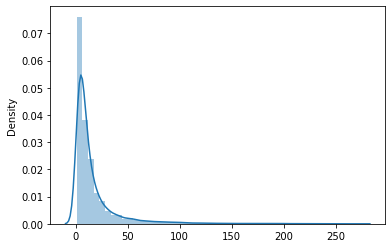

In [7]:
doc_lengths = []

for sentence in sentences:

    # get rough token count distribution
    tokens = nltk.word_tokenize(sentence)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [8]:
np.average(doc_lengths)

16.440044147244045

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most responses will fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [9]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [11]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [12]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=300):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [13]:
dataset = GPT2Dataset(sentences, tokenizer, max_length=300)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

13,862 training samples
1,541 validation samples


In [14]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [15]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [16]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [18]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [19]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [20]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  6,931. Loss: 0.522867739200592.   Elapsed: 0:00:13.
0:  bipartisan the best to go to that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  6,931. Loss: 0.16487811505794525.   Elapsed: 0:00:26.
0:  increasing all you want to see, you know, this was at which I was a, you know, just like, like, you know, you know, you know. The same like. the like. Just it. It was like like the time he didn like that to, he in the it's like is in the know something was like like like like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  6,931. Loss: 0.38007035851478577.   Elapsed: 0:00:39.
0: day I mean.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  6,931. Loss: 0.07026968896389008.   Elapsed: 0:00:52.
0:  Hang Oh shit. You need to drink alcohol to stay comfortable. Oh, there's got to be like a bunch of drinks together.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  6,931. Loss: 0.2802430987358093.   Elapsed: 0:01:05.
0:  foods Oh, it's just some sort of I'm saying, this is crazy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  6,931. Loss: 0.7590227723121643.   Elapsed: 0:01:18.
0:  trail The story was like a pretty good story. This is a pretty good story.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  6,931. Loss: 0.230006143450737.   Elapsed: 0:01:30.
0: intend Like, you know,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  6,931. Loss: 0.1203782856464386.   Elapsed: 0:01:43.
0:  surround I think you are driving a little bit like the road itself. You drive. That has really just been in to that thing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  6,931. Loss: 0.19454237818717957.   Elapsed: 0:01:56.
0:  reflex I think that for that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  6,931. Loss: 0.05283930525183678.   Elapsed: 0:02:08.
0:  display Oh no, but I'm going to take a with you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  6,931. Loss: 0.17641079425811768.   Elapsed: 0:02:21.
0:  pastor I feel like a no for the first time in this world on that. That's really good. That's what I think the best thing is is to know that this isn't like a new ideas, but like it has no actual reason and no any way to learn. I think we can. It's really nice and good idea that like in, I think, you got a wonderful idea about why it was interesting because it's like a lot of what I'm saying is so much more interesting to me than how they do different things, how it works in the best way, but like my ideas and everything really has no idea of what they're going to be and do what they're saying, right? I think it's cool. I think I mean I think if it's not what I want and so I think it is something that I thought of like, you know, then I think I was looking at the last possible way to learn this.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  6,931. Loss: 0.15536488592624664.   Elapsed: 0:02:37.
0:  illicit yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  6,931. Loss: 0.06673315912485123.   Elapsed: 0:02:49.
0:  Liberation Yeah, that's what we can do if you can call us.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  6,931. Loss: 0.19331210851669312.   Elapsed: 0:03:02.
0:  Nam You're so silly. I'll do like.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  6,931. Loss: 0.3830130100250244.   Elapsed: 0:03:15.
0: ION I think there is no longer that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  6,931. Loss: 0.03644636645913124.   Elapsed: 0:03:27.
0:  glimpse Okay.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  6,931. Loss: 0.22872254252433777.   Elapsed: 0:03:40.
0:  Laure I know it looks like this cuz you are going to give him a new tool for picking it up like a tool like to make a big part of like like the day when it's like a full time trip from like a walk to like a walkie and the days after to me in it, and you feel like we're trying to figure out what you feel like taking him in, you know, a more deeper dive than I just feel like we could be a whole new territory.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  6,931. Loss: 0.09784345328807831.   Elapsed: 0:03:54.
0: ism It is my house is really good. The house is so pretty good that you have to learn how to make it so much easier for people with big hands to learn how to do things. What is the most difficult one?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  6,931. Loss: 0.3584214448928833.   Elapsed: 0:04:07.
0: oun Sorry, my God.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  6,931. Loss: 0.2800091803073883.   Elapsed: 0:04:20.
0:  election We can just get it. I want to see, you know?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  6,931. Loss: 0.0861574038863182.   Elapsed: 0:04:33.
0:  crazy It's just that it's just like an at like this, just kind of like, if like these people are just kind of like the people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  6,931. Loss: 0.08944715559482574.   Elapsed: 0:04:46.
0:  bench I mean this is one of my best friends, but I also also want to know, this is a little bit of my biggest enemy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  6,931. Loss: 0.06393299996852875.   Elapsed: 0:04:59.
0:  incorporated I think we have so much.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  6,931. Loss: 0.13595342636108398.   Elapsed: 0:05:11.
0: Peter Oh wow.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  6,931. Loss: 0.15650612115859985.   Elapsed: 0:05:24.
0: uring Yeah, it's. It's a thing I'm really grateful for the project as far as he wants. Okay. Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  6,931. Loss: 1.5585219860076904.   Elapsed: 0:05:37.
0:  reproductive Like they have that it's not that like. I mean, they can walk to the back, but you don't like me cuz I'm in the back area of the people, you need to just walk in on a walk. She's going to like one of them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  6,931. Loss: 0.11773976683616638.   Elapsed: 0:05:50.
0:  zone Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  6,931. Loss: 0.2923232913017273.   Elapsed: 0:06:03.
0:  commits I think the best way I can use this. I think the best way to use it is in a way that's


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  6,931. Loss: 0.4880084693431854.   Elapsed: 0:06:16.
0:  irony But that's why I'm always just just saying that it's about like a ton of people would have been comfortable building a building that it would like that. It's like it would also be an interesting thing to do right in the midst to make of an accurate and even more accurate, accurate and accurate opinion of all the different different things that are going to happen on. And we feel like, right now, I'm wondering if like, this person, you know, there was like a lot of the same stuff, you know, that she was doing because she always feel like the thing in which people know, they still feel the same thing and then you know that, people you know, some people felt like it was nothing because of it, you know, and that's exactly what happened. So,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  6,931. Loss: 0.5969514846801758.   Elapsed: 0:06:31.
0:  Sah What did you do?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  6,931. Loss: 0.9233952760696411.   Elapsed: 0:06:43.
0:  Bryan I love it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  6,931. Loss: 0.07730820029973984.   Elapsed: 0:06:56.
0:  spirits What can I want to say to you?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  6,931. Loss: 0.144855797290802.   Elapsed: 0:07:09.
0:  sees Not sure if they have them out like I thought there was a lot of the time until you told me about me until I was


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  6,931. Loss: 0.22748622298240662.   Elapsed: 0:07:22.
0:  hungry Yeah, you go to the bathroom.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  6,931. Loss: 0.27976953983306885.   Elapsed: 0:07:34.
0:  PT No, no, no.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  6,931. Loss: 0.10320039093494415.   Elapsed: 0:07:47.
0: ü Yeah, I'm going to send it back to the family.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  6,931. Loss: 0.14306369423866272.   Elapsed: 0:08:00.
0: ruce Call me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  6,931. Loss: 0.1507011353969574.   Elapsed: 0:08:12.
0:  derivatives No, I'm just I need. I need so many things.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  6,931. Loss: 0.09574035555124283.   Elapsed: 0:08:25.
0:  Yeah, I'm so fun.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  6,931. Loss: 0.05754154548048973.   Elapsed: 0:08:38.
0:  remembering Like you can really see if I can get into the bathroom. You do the bathroom for two sec. I can just sit, wait to go to get my back. So like you can tell me something but it's like the bathroom to be outside of it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  6,931. Loss: 0.24338814616203308.   Elapsed: 0:08:51.
0:  Sources Yes, exactly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  6,931. Loss: 0.23031149804592133.   Elapsed: 0:09:04.
0: ems Yeah, I just I also like my friend will be cool. Like when you want like a random.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  6,931. Loss: 0.12191437184810638.   Elapsed: 0:09:16.
0: tz You know what it is?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  6,931. Loss: 0.1637502908706665.   Elapsed: 0:09:29.
0: matic No one is that we have no clue how what we like how the city is. But like, how do I get back from in the middle of a time? Just you know, how are they? How is a little bit of like on the side side that, like I like the middle of a, like, I mean, this is it is in a little bit of that is going to be fun and it's at your side. Like, I mean, what is a little bit of like, like not like a little bit just like a small like that. It's like you know how are in some way. They're so, but not like the very big, just it's you know if you can't just be like a little bit like, if it's you'll go to and I feel like like I'm in the middle of the middle of like you know, you know,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  6,931. Loss: 0.3866839110851288.   Elapsed: 0:09:44.
0:  synd I don't need to worry about that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  6,931. Loss: 0.6669034361839294.   Elapsed: 0:09:57.
0:  gam Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  6,931. Loss: 0.09680845588445663.   Elapsed: 0:10:10.
0:  injury What should I be doing?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  6,931. Loss: 0.5025280714035034.   Elapsed: 0:10:22.
0: aza A wonderful.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  6,931. Loss: 0.43898576498031616.   Elapsed: 0:10:35.
0:  membrane Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  6,931. Loss: 0.34913313388824463.   Elapsed: 0:10:47.
0: ijing And I think, like, like, I'm actually, I'm just wondering. Why, there is no real way to walk here. Just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  6,931. Loss: 0.33094143867492676.   Elapsed: 0:11:00.
0:  cast Yeah, we'll go for.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  6,931. Loss: 0.101313516497612.   Elapsed: 0:11:13.
0:  purch I know a lot of him I think. So that I think I can be this person on your project. I need to be the right person that he's doing this in the movie, like I I'm gonna do that as well, I want to be like I want to go to the movie that I want to take back into the movie. I want to have that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  6,931. Loss: 0.31569573283195496.   Elapsed: 0:11:27.
0:  shoulders I want to be on the street in the middle of the ocean and one of them was like if you look a little bit.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  6,931. Loss: 0.35799577832221985.   Elapsed: 0:11:40.
0:  built Yeah, definitely.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  6,931. Loss: 1.5072729587554932.   Elapsed: 0:11:52.
0:  openly Let's see if we got a cigarette, right?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  6,931. Loss: 0.07715009897947311.   Elapsed: 0:12:05.
0:  halted I think about that you have no hope, so that's what they were. But I know you had a good experience of living in school with one of the other people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  6,931. Loss: 0.107761450111866.   Elapsed: 0:12:18.
0:  Nik I feel like I'm just like, I don't know I'm just like I still don't know what the problem is the same thing that?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  6,931. Loss: 0.38185471296310425.   Elapsed: 0:12:31.
0:  tin Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  6,931. Loss: 0.1589304506778717.   Elapsed: 0:12:44.
0:  clinical Like, why are people who say people who don't be able to take that at a meet up with people who don't want to talk, I'm going to show them and ask them. I'm going to walk down to the back of a really high school. They're going to do it again soon if there's a bad situation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  6,931. Loss: 0.1607261747121811.   Elapsed: 0:12:57.
0: lections This is it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  6,931. Loss: 0.4952600300312042.   Elapsed: 0:13:10.
0: els I don't have to get back. I do that cuz it is what I want. I don't want to do it now.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  6,931. Loss: 0.13117173314094543.   Elapsed: 0:13:23.
0: lab I can. And I can. I can. I can get a machine that we can use.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  6,931. Loss: 0.28707751631736755.   Elapsed: 0:13:36.
0:  triple Let's put it. We can do it. Let's make sure that you can.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  6,931. Loss: 0.09165384620428085.   Elapsed: 0:13:49.
0: 220 Like I will. I'm the very much she's, she's, she is so I think she has a way to, is like, I can have an idea about what she can do it. I love to do it. I love to do it. But you know


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  6,931. Loss: 0.18386521935462952.   Elapsed: 0:14:02.
0:  See You know,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  6,931. Loss: 0.09028279781341553.   Elapsed: 0:14:15.
0: @@ I'd like like.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  6,931. Loss: 0.05873508378863335.   Elapsed: 0:14:27.
0:  host Really.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  6,931. Loss: 0.33531394600868225.   Elapsed: 0:14:40.
0: role I'm sure it's on the outside.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  6,931. Loss: 0.09090761840343475.   Elapsed: 0:14:53.
0: iac That's okay.

  Average training loss: 0.26
  Training epoch took: 0:14:56

Running Validation...
  Validation Loss: 0.26
  Validation took: 0:00:28

======== Epoch 2 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  6,931. Loss: 0.07860219478607178.   Elapsed: 0:00:13.
0:  LD What is the sky again?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  6,931. Loss: 0.27896252274513245.   Elapsed: 0:00:25.
0:  Listen Yeah, I'm going to have. So there's nothing I'm saying we would have felt closer. I got better to do it. I'm going to do some good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  6,931. Loss: 0.4863932430744171.   Elapsed: 0:00:38.
0:  dy


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  6,931. Loss: 0.9036744832992554.   Elapsed: 0:00:51.
0:  Domestic and No


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  6,931. Loss: 0.12733426690101624.   Elapsed: 0:01:03.
0:  beneficiaries with like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  6,931. Loss: 0.05681893974542618.   Elapsed: 0:01:16.
0:  Title I think we should be able to make it. You know I know we'm not know you can't make it even if he's he's like, it's like a good one. So I can't stop like, but like it was a good spot and what you're going I'm like it's really like some real, I know what it's really like the way's not that I'm like that we can't want to do it like, but that's going It's just like a good spot in one in terms.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  6,931. Loss: 0.5804334282875061.   Elapsed: 0:01:30.
0:  μa and that's like the thing about that's going to know. Like a good idea for like a really quick thing to know what a fast and also, even like the possibility that that if you're like a hundred different ways that that you can say like a different ways of the process at that way that we'll be possible. Do like a different kinds of things in which, like an idea. We won't be able to just walk.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  6,931. Loss: 0.07662118226289749.   Elapsed: 0:01:44.
0:  selling And I'm just like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  6,931. Loss: 0.04150693118572235.   Elapsed: 0:01:57.
0:  migrant Oh, that's a lot of those people, in the city at least all the time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  6,931. Loss: 0.3207824230194092.   Elapsed: 0:02:10.
0: ively I'm


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  6,931. Loss: 0.07041040062904358.   Elapsed: 0:02:22.
0:  order Can you do some kind of like how can I see what you should be in the game itself as well as I really just like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  6,931. Loss: 0.6775550246238708.   Elapsed: 0:02:35.
0:  VPN We were going to be like, oh yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  6,931. Loss: 0.3255452811717987.   Elapsed: 0:02:48.
0:  explanation Oh my God


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  6,931. Loss: 0.5290864706039429.   Elapsed: 0:03:01.
0:  Bach Yes, that's exactly what I'm saying.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  6,931. Loss: 0.30270475149154663.   Elapsed: 0:03:13.
0:  folder What was it the most that we had ever, we could have like it would like an even like a


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  6,931. Loss: 0.05981157720088959.   Elapsed: 0:03:26.
0:  building But then I feel like I just got like, I don't know how to make sure this is what is that that, so that's why I like, I just felt like, I've been feeling. It was just like, it's going to feel like that sort of like feel like I could have easily put it into like something.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  6,931. Loss: 0.19172626733779907.   Elapsed: 0:03:40.
0:  Babylon I'm like, I'm like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  6,931. Loss: 0.08572716265916824.   Elapsed: 0:03:52.
0: perial It's always a wide area in some way I'm just I'm in a place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  6,931. Loss: 0.10143771022558212.   Elapsed: 0:04:05.
0:  rents I don't want to go to work.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  6,931. Loss: 0.3295346200466156.   Elapsed: 0:04:18.
0:  Reg I think I think I just need to show you a picture of it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  6,931. Loss: 0.23398296535015106.   Elapsed: 0:04:31.
0: olas It's not just to be that stupid stupid stupid.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  6,931. Loss: 0.13610270619392395.   Elapsed: 0:04:43.
0:  responses Okay, I got a coffee table with, that's like it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  6,931. Loss: 0.17337557673454285.   Elapsed: 0:04:56.
0:  attendance But you don't give a shit. It's like you don't give a shit for the people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  6,931. Loss: 0.12903599441051483.   Elapsed: 0:05:09.
0:  rigid I have no clue why I'll call that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  6,931. Loss: 0.16143092513084412.   Elapsed: 0:05:22.
0: gro No, I would.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  6,931. Loss: 0.34409502148628235.   Elapsed: 0:05:34.
0:  Gre So, you go on, you know, right, right, right now. Right now. Right now. Right now is what the date is that what


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  6,931. Loss: 0.8074953556060791.   Elapsed: 0:05:47.
0: ura Yeah, exactly. It was in the same way. Yeah. Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  6,931. Loss: 0.7829813361167908.   Elapsed: 0:06:00.
0:  2020 You know, maybe if you've been in the past, if you've been feeling a lot of like if you've been feeling.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  6,931. Loss: 0.10871512442827225.   Elapsed: 0:06:13.
0:  charging No.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  6,931. Loss: 0.10021188855171204.   Elapsed: 0:06:26.
0:  Sar Just a single piece.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  6,931. Loss: 0.1534109264612198.   Elapsed: 0:06:38.
0:  Jas I thought that was just about the fact that like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  6,931. Loss: 0.05451953783631325.   Elapsed: 0:06:51.
0:  permit Yeah, I don't. Yeah, no, I'm fine. I'm just thinking about the fact that it's just about sort of like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  6,931. Loss: 0.2787151336669922.   Elapsed: 0:07:04.
0:  Administrator Yeah, you can tell me so I can be the case in the city.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  6,931. Loss: 0.05814419686794281.   Elapsed: 0:07:17.
0:  EVENTS Okay, so you can do that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  6,931. Loss: 0.18517903983592987.   Elapsed: 0:07:29.
0:  Mental Why not the same thing? Why?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  6,931. Loss: 0.9383755326271057.   Elapsed: 0:07:42.
0: ids I love.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  6,931. Loss: 0.1931372731924057.   Elapsed: 0:07:55.
0: ceans That's crazy. Yeah, but the question of who it is.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  6,931. Loss: 0.9448815584182739.   Elapsed: 0:08:07.
0:  genetically Yeah, exactly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  6,931. Loss: 0.23596395552158356.   Elapsed: 0:08:20.
0:  advice Now. Yeah, I'll do all this for you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  6,931. Loss: 0.12204733490943909.   Elapsed: 0:08:33.
0:  incomplete I know it's more organized. It's much more organized.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  6,931. Loss: 0.26920950412750244.   Elapsed: 0:08:46.
0: comment But like, what is like a crazy thing that's like the old is, is I'm so fucking like a crazy ass.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  6,931. Loss: 0.07876620441675186.   Elapsed: 0:08:58.
0:  pilot No.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  6,931. Loss: 0.21265217661857605.   Elapsed: 0:09:11.
0: gers Yeah, I know. That's beautiful.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  6,931. Loss: 0.13264591991901398.   Elapsed: 0:09:24.
0:  mutation I'll just take this morning to do that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  6,931. Loss: 0.2589792013168335.   Elapsed: 0:09:36.
0:  Driver Yes, so I think maybe it's not too much.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  6,931. Loss: 0.07742057740688324.   Elapsed: 0:09:49.
0: iti It's wonderful.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  6,931. Loss: 0.2547156512737274.   Elapsed: 0:10:02.
0: fff I feel like I think that's pretty good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  6,931. Loss: 0.41404810547828674.   Elapsed: 0:10:14.
0: rimination I was.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  6,931. Loss: 0.2337869256734848.   Elapsed: 0:10:27.
0: aque Yeah, exactly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  6,931. Loss: 0.1321289837360382.   Elapsed: 0:10:40.
0: lee That's what I'm saying. This is like an established. I wanted to try to try to try to try to figure out what I wanted to try to try is that he's so, he doesn't often times.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  6,931. Loss: 0.13808177411556244.   Elapsed: 0:10:53.
0:  Alzheimer She's not really hot anymore.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  6,931. Loss: 0.05128956958651543.   Elapsed: 0:11:05.
0:  checking What does this say?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  6,931. Loss: 0.05406615138053894.   Elapsed: 0:11:18.
0: nesium Yeah, this is crazy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  6,931. Loss: 0.39082297682762146.   Elapsed: 0:11:31.
0:  1957 The house is so much better when I get a new clothes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  6,931. Loss: 0.06162106990814209.   Elapsed: 0:11:43.
0: manship Let's get a few. Let's go. Let's go.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  6,931. Loss: 0.3696439564228058.   Elapsed: 0:11:56.
0:  understand I thought about this. I just felt the feeling of like that's why I didn't like it because I was so much.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  6,931. Loss: 0.1420210599899292.   Elapsed: 0:12:09.
0:  passion No.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  6,931. Loss: 0.026784226298332214.   Elapsed: 0:12:22.
0:  curved I'm not even looking at anything.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  6,931. Loss: 0.09962841123342514.   Elapsed: 0:12:34.
0:  An Yeah, I know, but I also like it. I'll be really grateful for her like, like she should be like I just kind of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  6,931. Loss: 0.0210442952811718.   Elapsed: 0:12:47.
0: otti You don't have to walk in that place when it was like I went to my family in the two places in the two places in the two places and I was like one kind of connection that was like a familial connection and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  6,931. Loss: 0.15762268006801605.   Elapsed: 0:13:00.
0:  intake We had a little bit of sex.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  6,931. Loss: 0.17528268694877625.   Elapsed: 0:13:13.
0:  Ts I'm not saying that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  6,931. Loss: 0.10404312610626221.   Elapsed: 0:13:26.
0:  Main Sorry.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  6,931. Loss: 0.19512881338596344.   Elapsed: 0:13:38.
0:  tem You can like, I'm just not in Sweden, like an assassin.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  6,931. Loss: 0.36387601494789124.   Elapsed: 0:13:51.
0:  Click No, no, no. I'm, you know, there's, there's no one else who's on this team was like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  6,931. Loss: 0.09389876574277878.   Elapsed: 0:14:04.
0:  XV Are you at?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  6,931. Loss: 0.1056513860821724.   Elapsed: 0:14:17.
0:  dorm It. Yes, I can I can be strong.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  6,931. Loss: 0.28231072425842285.   Elapsed: 0:14:29.
0:  upstream Yeah, we're not sure if we're just sure that we're just going to get a good feeling.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  6,931. Loss: 0.1519947350025177.   Elapsed: 0:14:42.
0: ال Okay.

  Average training loss: 0.23
  Training epoch took: 0:14:46

Running Validation...
  Validation Loss: 0.25
  Validation took: 0:00:28

======== Epoch 3 / 3 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  6,931. Loss: 0.08419455587863922.   Elapsed: 0:00:13.
0: aria Yes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  6,931. Loss: 0.14170154929161072.   Elapsed: 0:00:25.
0: PG I think.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  6,931. Loss: 0.01714148186147213.   Elapsed: 0:00:38.
0: Ill Don't say it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  6,931. Loss: 0.029354261234402657.   Elapsed: 0:00:50.
0:  automated Oh yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  6,931. Loss: 0.22297152876853943.   Elapsed: 0:01:03.
0:  hiring You don't want to necessarily have conversations with someone, you know?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  6,931. Loss: 0.08999919146299362.   Elapsed: 0:01:16.
0:  tweeting Oh, and I just went through it again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  6,931. Loss: 0.047268033027648926.   Elapsed: 0:01:28.
0: abit Yeah, I know of him.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  6,931. Loss: 0.07347697764635086.   Elapsed: 0:01:41.
0:  ii I'm sorry.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  6,931. Loss: 0.06224910914897919.   Elapsed: 0:01:54.
0: clip The ones who we did not want them to be honest.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  6,931. Loss: 0.11524956673383713.   Elapsed: 0:02:06.
0:  Franc That's the only really, really good thing on the best albums possible.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  6,931. Loss: 0.18397226929664612.   Elapsed: 0:02:19.
0:  listening That's why I like it. I'm not like it's not like it just seems to just keep him entertained.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  6,931. Loss: 0.23533333837985992.   Elapsed: 0:02:32.
0:  EU Okay. Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  6,931. Loss: 0.07216324657201767.   Elapsed: 0:02:45.
0:  incredible Yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  6,931. Loss: 0.5710873007774353.   Elapsed: 0:02:57.
0:  TY Oh, so crazy. I'm going to be like, I am going to be like a weirdo, a hippo.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  6,931. Loss: 0.11714161187410355.   Elapsed: 0:03:10.
0:  230 I like the thing is, you know, and that's something that really bad about my dad's, as well.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  6,931. Loss: 0.10444986820220947.   Elapsed: 0:03:23.
0:  Tigers But that's like a very common thing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  6,931. Loss: 0.1125142052769661.   Elapsed: 0:03:36.
0: CD But just like it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  6,931. Loss: 0.36867693066596985.   Elapsed: 0:03:48.
0:  unbelievable I think I'd I just feel like I know. Like my grandpa lives in living in New York, so it's like a family.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  6,931. Loss: 1.7570953369140625.   Elapsed: 0:04:01.
0: Robert I think like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  6,931. Loss: 0.13511936366558075.   Elapsed: 0:04:14.
0:  Contact It just doesn't work.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  6,931. Loss: 0.41022008657455444.   Elapsed: 0:04:26.
0:  fountain I do know.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  6,931. Loss: 0.2836305797100067.   Elapsed: 0:04:39.
0:  clash When I say no to a parent, they'll take my kid to a place.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  6,931. Loss: 0.08805117756128311.   Elapsed: 0:04:52.
0:  commod I'm going to be.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  6,931. Loss: 0.0420386865735054.   Elapsed: 0:05:04.
0:  algorithm The great pain, the great fucking love for you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  6,931. Loss: 0.0453353188931942.   Elapsed: 0:05:17.
0:  accurate I think.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  6,931. Loss: 0.09790458530187607.   Elapsed: 0:05:30.
0: ado But like that thing is.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  6,931. Loss: 0.06051590293645859.   Elapsed: 0:05:42.
0:  regulate But I thought that was so crazy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  6,931. Loss: 0.09145528823137283.   Elapsed: 0:05:55.
0: eway I really want, I really want to do, you know, that's not to be me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  6,931. Loss: 0.331278532743454.   Elapsed: 0:06:08.
0: ittee Look at that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  6,931. Loss: 0.19650936126708984.   Elapsed: 0:06:20.
0:  Jackie A beautiful.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  6,931. Loss: 0.06356754153966904.   Elapsed: 0:06:33.
0: He I can just be like,


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  6,931. Loss: 0.050916459411382675.   Elapsed: 0:06:46.
0:  wired That's crazy. But not that it was on.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  6,931. Loss: 0.09778916835784912.   Elapsed: 0:06:58.
0:  frequ You shouldn't worry.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  6,931. Loss: 0.2443855255842209.   Elapsed: 0:07:11.
0:  views All this is just like the new product that we found. We might we might just be able to discover some new product to really cuz it's just like like, everyone is just being fun. We just all like, no one's walking walking on this new product. Like, like, this new product that was like the best experiences of life is just like, I'm walking on this new product. You know, just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  6,931. Loss: 0.18603652715682983.   Elapsed: 0:07:25.
0:  Strategy I will get a good coffee.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  6,931. Loss: 0.21019500494003296.   Elapsed: 0:07:37.
0:  radio It's not it's like just a good person. That's not nice at all. I'm just so good. And honestly, I think I think it's really nice out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  6,931. Loss: 0.07156696915626526.   Elapsed: 0:07:50.
0: oult It was delicious.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  6,931. Loss: 0.16222402453422546.   Elapsed: 0:08:03.
0:  Rein They come.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  6,931. Loss: 0.16439057886600494.   Elapsed: 0:08:16.
0:  proc That's it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  6,931. Loss: 0.12716306746006012.   Elapsed: 0:08:28.
0:  abuses Oh yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  6,931. Loss: 0.14282666146755219.   Elapsed: 0:08:41.
0:  wa And not see the house anymore because everyone says it's better when you're walking. You can leave it to like build your own network like I wouldn't necessarily. If you would like build your own network around people and people like build your own network around people like the streets and stuff like that because they don't like, you know, they don't know how to do that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  6,931. Loss: 0.10777278989553452.   Elapsed: 0:08:55.
0: lected We like it like this is.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  6,931. Loss: 0.07143577188253403.   Elapsed: 0:09:07.
0:  temple We just want you to look at the map on the map. I want you to understand the map on the map.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  6,931. Loss: 0.14350782334804535.   Elapsed: 0:09:20.
0:  lod It could be too cold outside. You know, it could be too cold outside for the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  6,931. Loss: 0.8553048372268677.   Elapsed: 0:09:33.
0:  Rio No, no. No. I don't, I think. No, that's why it's like a Seminole. But like, oh, you know that like a Seminole, right? Why don't we like have them on Seminole to like the? How can we have Seminole? It doesn't matter that like a Seminole? Because we've never had. I've never felt like, how can we have it? That's how can we have it? How can we have, how can we have it happen to like all of our friends? I had no clue what that like, just a random random guy that he is because they were like, well-liked, high in high school.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  6,931. Loss: 0.4824960231781006.   Elapsed: 0:09:48.
0:  Pence Oh no, no, you didn't want to make this like a list of like it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  6,931. Loss: 0.0444854274392128.   Elapsed: 0:10:00.
0:  Steven Oh no, no. I'm just just I'm I'm just confused that I know everything but I just honestly I don't know.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  6,931. Loss: 0.061633139848709106.   Elapsed: 0:10:13.
0:  discourse I feel like I have to prove I have a certain level of self that like it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  6,931. Loss: 0.10180222988128662.   Elapsed: 0:10:26.
0:  accessory Yeah, I think he was, he was very, he was very good.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  6,931. Loss: 0.7037411332130432.   Elapsed: 0:10:39.
0: ul But my question is, if you're a fan, you're not like me.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  6,931. Loss: 0.11507972329854965.   Elapsed: 0:10:52.
0:  sliding What's a good thing?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  6,931. Loss: 0.2854204475879669.   Elapsed: 0:11:04.
0:  Dell Yeah, I'm just like feeling like a lot of stuff that is like it's in a very, very, very very, very, very


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  6,931. Loss: 0.039035599678754807.   Elapsed: 0:11:17.
0: ius Like, I mean, I am I do like I have to think of my way of being, you know. And so it's like, I'm in a very much what it is. I'm I'm just walking around a project, right? That's what I wanted, I wanted to do that with the microphone, and the project was to do the same thing with. That, you know, who I want to do the audio thing with this microphone. And I'm just walking around, walking around my notes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  6,931. Loss: 0.09370661526918411.   Elapsed: 0:11:32.
0: sided In some way.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  6,931. Loss: 0.1439385861158371.   Elapsed: 0:11:44.
0:  WP Really cool. The only cop that I've ever dated this guy is so cute.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  6,931. Loss: 0.09125736355781555.   Elapsed: 0:11:57.
0:  exert Yeah, yeah, yeah.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  6,931. Loss: 0.17943905293941498.   Elapsed: 0:12:09.
0: inian Yeah. And


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  6,931. Loss: 0.8055886030197144.   Elapsed: 0:12:22.
0:  electricity yeah, but it's very like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  6,931. Loss: 0.0818801075220108.   Elapsed: 0:12:35.
0:  Aviation Yeah, we have to take this at my house, take the three p.m. at like 1.m. and 1 m. at 2.m. at 2.m. a.m. and 1.m. and 1 and 2.m. are two people on each side and


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  6,931. Loss: 0.13361620903015137.   Elapsed: 0:12:48.
0:  encoding A beautiful building.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  6,931. Loss: 0.16916202008724213.   Elapsed: 0:13:01.
0: fit Not just not.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  6,931. Loss: 0.05216436833143234.   Elapsed: 0:13:13.
0:  wife This.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  6,931. Loss: 0.08958493173122406.   Elapsed: 0:13:26.
0: iley Do these things. Can I please? Yes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  6,931. Loss: 0.3875696659088135.   Elapsed: 0:13:39.
0: stage We didn't make the decision.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  6,931. Loss: 0.13774965703487396.   Elapsed: 0:13:51.
0: hat I mean, like the people who like, oh you know I feel like


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  6,931. Loss: 0.10048572719097137.   Elapsed: 0:14:04.
0: Rich You know, and so if I do that, then I can tell you all about this. I also ask you to come and see that.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  6,931. Loss: 0.12497684359550476.   Elapsed: 0:14:17.
0: � I think it's beautiful to meet you. I thought you'd like to.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  6,931. Loss: 0.061623767018318176.   Elapsed: 0:14:30.
0:  pretending But it might even be a little less like just like if I'm honest with myself as a fan that I think it might be just, yeah, I think I think it's, I think it's going to be really tough because they don't know. I think it might be really, really exciting because I've only been like just like, I know it's just I don't have to spend it like my time at. That's been really cool.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  6,931. Loss: 0.15002350509166718.   Elapsed: 0:14:44.
0:  PCB Let me see, I don't like that. I don't even remember what he was looking at like the crazy things that were happening.

  Average training loss: 0.18
  Training epoch took: 0:14:48

Running Validation...
  Validation Loss: 0.26
  Validation took: 0:00:28

Training complete!
Total training took 0:45:53 (h:mm:ss)


Let's view the summary of the training process.

In [21]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.26,0.26,0:14:56,0:00:28
2,0.23,0.25,0:14:46,0:00:28
3,0.18,0.26,0:14:48,0:00:28


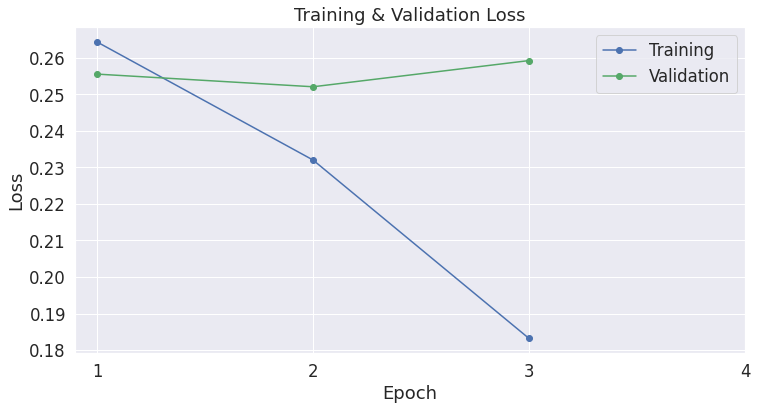

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [26]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/gdrive/MyDrive/model_save2/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to /content/gdrive/MyDrive/model_save2/


('/content/gdrive/MyDrive/model_save2/tokenizer_config.json',
 '/content/gdrive/MyDrive/model_save2/special_tokens_map.json',
 '/content/gdrive/MyDrive/model_save2/vocab.json',
 '/content/gdrive/MyDrive/model_save2/merges.txt',
 '/content/gdrive/MyDrive/model_save2/added_tokens.json')

In [27]:
!ls -l --block-size=K /content/gdrive/MyDrive/model_save1/

total 499775K
-rw------- 1 root root      1K Aug 22 17:44 added_tokens.json
-rw------- 1 root root      1K Aug 22 17:44 config.json
-rw------- 1 root root    446K Aug 22 17:44 merges.txt
-rw------- 1 root root 498448K Aug 22 17:44 pytorch_model.bin
-rw------- 1 root root      1K Aug 22 17:44 special_tokens_map.json
-rw------- 1 root root      1K Aug 22 17:44 tokenizer_config.json
-rw------- 1 root root    878K Aug 22 17:44 vocab.json


In [28]:
!ls -l --block-size=M /content/gdrive/MyDrive/model_save1/pytorch_model.bin

-rw------- 1 root root 487M Aug 22 17:44 /content/gdrive/MyDrive/model_save1/pytorch_model.bin


In [29]:
#output_dir = '/content/gdrive/MyDrive/model_save1'
# # Load a trained model and vocabulary that you have fine-tuned
# Tell pytorch to run this model on the GPU.
#device = torch.device("cuda")
#model.cuda()
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [1]:
model.eval()

prompt = "<|startoftext|> The world is too small for me."

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                min_length = 20,
                                max_length = 900,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

NameError: ignored